## Setup

In [39]:
! pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121

Looking in indexes: https://download.pytorch.org/whl/cu121


In [40]:
! pip install matplotlib

In [41]:
! pip install tqdm

## Test

In [42]:
import torch
x = torch.rand(5, 3)
print(x)

tensor([[0.1853, 0.2886, 0.1887],
        [0.9303, 0.8693, 0.3201],
        [0.5390, 0.2293, 0.1005],
        [0.1621, 0.2166, 0.4748],
        [0.3265, 0.5470, 0.0288]])


In [43]:
import torch
torch.cuda.is_available()

True

In [44]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [45]:
print(device)

cuda


In [46]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
import os

The goal of this image classification model is to classify an image as one of 12 classes, for the purposes of solving Google reCAPTCHA. The classes are:
bicycle, bridge, bus, car, chimney, crosswalk, hydrant, motorcycle, other, palm, stair, traffic light

The data is located in the `data` directory. The training data is located in the `data/train` directory, and the test data is located in the `data/test` directory. The training data is organized into 12 subdirectories, one for each class. Each directory consists of images of that class, with the name of the image being the class label (i.e. Bicycle (7).jpg, Bus (78).jpg, etc). The test data is organized in the same way. Each image is a 120x120 pixel RGB image.

Rather than using a pretrained model like ResNet18, I am creating my own image classification model. The model is trained using the SGD optimizer with a learning rate of 0.01, categorical crossentropy loss, and accuracy metric. The model is trained for 10 epochs with a batch size of 32.

The model is evaluated on the test data using the accuracy metric.

In [47]:
# data processing
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(120), # resize the image to the given size
        transforms.RandomHorizontalFlip(), # randomly flip image horizontally
        transforms.ToTensor(), # convert image to tensor
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]) # 0-1 to [-1, 1], formula (x - mean) / std
    ]),
    'val': transforms.Compose([
        transforms.Resize(120),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ]),
}

In [74]:
# data loading
train_dir = 'C://Users//Manas//Desktop//captcha//data//train'
val_dir = 'C://Users//Manas//Desktop//captcha//data//test'

train_loader = torch.utils.data.DataLoader(
    datasets.ImageFolder(train_dir, data_transforms['train']),
    batch_size=64, shuffle=True, num_workers=4
)
test_loader = torch.utils.data.DataLoader(
    datasets.ImageFolder(val_dir, data_transforms['val']),
    batch_size=32, shuffle=True, num_workers=4
)

In [49]:
# categories
categories = os.listdir(train_dir)

In [50]:
print(categories)

['Bicycle', 'Bridge', 'Bus', 'Car', 'Chimney', 'Crosswalk', 'Hydrant', 'Motorcycle', 'Other', 'Palm', 'Stair', 'Traffic Light']


In [51]:
import torch.nn.functional as F

# model
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()

        # First convolutional layer
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.relu1 = nn.ReLU()
        # Adding Dropout layer
        self.dropout1 = nn.Dropout(0.2)

        # Second convolutional layer
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.relu2 = nn.ReLU()
        # Adding Dropout layer
        self.dropout2 = nn.Dropout(0.2)

        # Pooling layer
        self.pool = nn.MaxPool2d(2, 2)

        # Third convolutional layer
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.relu3 = nn.ReLU()
        # Adding Dropout layer
        self.dropout3 = nn.Dropout(0.3)

        # Fourth convolutional layer
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.relu4 = nn.ReLU()
        # Adding Dropout layer
        self.dropout4 = nn.Dropout(0.3)

        # Fully connected layers
        # Calculating the flattened size based on your pooling and conv layers
        # Assuming input size [120x120] -> after 3 pooling layers [15x15]
        self.fc1 = nn.Linear(15*15*256, 1024)
        self.relu5 = nn.ReLU()
        # Adding Dropout before the final layer
        self.dropout5 = nn.Dropout(0.5)

        # Output layer
        self.fc2 = nn.Linear(1024, 12)

    def forward(self, x):
        # Apply first conv layer, batch normalization, ReLU, and dropout
        x = self.dropout1(self.relu1(self.bn1(self.conv1(x))))
        # Apply second conv layer, batch normalization, ReLU, pooling, and dropout
        x = self.pool(self.dropout2(self.relu2(self.bn2(self.conv2(x)))))
        # Apply third conv layer, batch normalization, ReLU, pooling, and dropout
        x = self.pool(self.dropout3(self.relu3(self.bn3(self.conv3(x)))))
        # Apply fourth conv layer, batch normalization, ReLU, and dropout
        x = self.dropout4(self.relu4(self.bn4(self.conv4(x))))
        # Apply pooling to reduce dimension
        x = self.pool(x)
        # Flatten and pass through the fully connected layer, ReLU, and dropout
        x = x.view(-1, 15*15*256)
        x = self.dropout5(self.relu5(self.fc1(x)))
        # Final output layer
        x = self.fc2(x)
        return x

In [52]:
from torchvision import models

model = models.resnet18(pretrained=True)

# Freeze model parameters (optional)
for param in model.parameters():
    param.requires_grad = False

num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 12)

model = model.to(device)

c:\Users\Manas\Desktop\captcha\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Manas\Desktop\captcha\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\Manas/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 67.8MB/s]


In [53]:
# loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [54]:
# counts
train_count = len(train_loader.dataset)
test_count = len(test_loader.dataset)

print(train_count, test_count)

9384 2346


In [55]:
from tqdm import tqdm

# Early stopping parameters
patience = 5
best_test_loss = float('inf')
counter_early_stop = 0
early_stop = False

# training
num_epochs = 50
train_losses, train_accuracies = [], []
test_losses, test_accuracies = [], []

for epoch in range(num_epochs):
    if not early_stop:
        model.train()
        train_loss = 0.0
        train_correct = 0

        train_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Train]')

        for inputs, labels in train_bar:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            train_correct += (preds == labels).sum().item()

            train_bar.set_postfix(loss=(train_loss / (train_bar.last_print_n + 1)), accuracy=(train_correct / train_count))

        # Calculate average loss and accuracy per epoch
        avg_train_loss = train_loss / train_count
        avg_train_accuracy = train_correct / train_count
        train_losses.append(avg_train_loss)
        train_accuracies.append(avg_train_accuracy)

        model.eval()
        test_loss = 0.0
        test_correct = 0

        test_bar = tqdm(test_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Test]')

        with torch.no_grad():
            for inputs, labels in test_bar:
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                test_loss += loss.item()
                _, preds = torch.max(outputs, 1)
                test_correct += (preds == labels).sum().item()

                test_bar.set_postfix(loss=(test_loss / (test_bar.last_print_n + 1)), accuracy=(test_correct / test_count))

        avg_test_loss = test_loss / test_count
        avg_test_accuracy = test_correct / test_count
        test_losses.append(avg_test_loss)
        test_accuracies.append(avg_test_accuracy)

        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Train Acc: {avg_train_accuracy:.4f}, Test Loss: {avg_test_loss:.4f}, Test Acc: {avg_test_accuracy:.4f}')

        # Check if test loss improved
        if avg_test_loss < best_test_loss:
            best_test_loss = avg_test_loss
            torch.save(model.state_dict(), 'best_model.pth')
            counter_early_stop = 0
        else:
            counter_early_stop += 1
            if counter_early_stop >= patience:
                print(f'Early stopping activated. Stopping training.')
                early_stop = True


Epoch 1/50 [Train]:   0%|          | 0/147 [00:00<?, ?it/s]

c:\Users\Manas\Desktop\captcha\.venv\Lib\site-packages\torch\nn\modules\conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ..\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
Epoch 1/50 [Test]: 100%|██████████| 74/74 [00:12<00:00,  5.88it/s, accuracy=0.611, loss=1.37] 


Epoch 1/50, Train Loss: 0.0261, Train Acc: 0.4795, Test Loss: 0.0404, Test Acc: 0.6113


Epoch 2/50 [Test]: 100%|██████████| 74/74 [00:12<00:00,  6.04it/s, accuracy=0.661, loss=1.1]  


Epoch 2/50, Train Loss: 0.0182, Train Acc: 0.6409, Test Loss: 0.0347, Test Acc: 0.6611


Epoch 3/50 [Test]: 100%|██████████| 74/74 [00:11<00:00,  6.28it/s, accuracy=0.674, loss=1.13] 


Epoch 3/50, Train Loss: 0.0162, Train Acc: 0.6674, Test Loss: 0.0322, Test Acc: 0.6743


Epoch 4/50 [Test]: 100%|██████████| 74/74 [00:12<00:00,  6.00it/s, accuracy=0.676, loss=0.983]


Epoch 4/50, Train Loss: 0.0151, Train Acc: 0.6864, Test Loss: 0.0310, Test Acc: 0.6765


Epoch 5/50 [Test]: 100%|██████████| 74/74 [00:12<00:00,  5.98it/s, accuracy=0.693, loss=0.957]


Epoch 5/50, Train Loss: 0.0145, Train Acc: 0.6963, Test Loss: 0.0302, Test Acc: 0.6931


Epoch 6/50 [Test]: 100%|██████████| 74/74 [00:12<00:00,  5.96it/s, accuracy=0.685, loss=0.947]


Epoch 6/50, Train Loss: 0.0142, Train Acc: 0.6993, Test Loss: 0.0295, Test Acc: 0.6854


Epoch 7/50 [Test]: 100%|██████████| 74/74 [00:12<00:00,  5.96it/s, accuracy=0.698, loss=0.914]


Epoch 7/50, Train Loss: 0.0137, Train Acc: 0.7123, Test Loss: 0.0288, Test Acc: 0.6982


Epoch 8/50 [Test]: 100%|██████████| 74/74 [00:11<00:00,  6.17it/s, accuracy=0.696, loss=0.992]


Epoch 8/50, Train Loss: 0.0134, Train Acc: 0.7193, Test Loss: 0.0288, Test Acc: 0.6957


Epoch 9/50 [Test]: 100%|██████████| 74/74 [00:11<00:00,  6.24it/s, accuracy=0.699, loss=0.976]


Epoch 9/50, Train Loss: 0.0132, Train Acc: 0.7168, Test Loss: 0.0283, Test Acc: 0.6991


Epoch 10/50 [Test]: 100%|██████████| 74/74 [00:11<00:00,  6.27it/s, accuracy=0.702, loss=0.975]


Epoch 10/50, Train Loss: 0.0131, Train Acc: 0.7207, Test Loss: 0.0283, Test Acc: 0.7016


Epoch 11/50 [Test]: 100%|██████████| 74/74 [00:11<00:00,  6.38it/s, accuracy=0.705, loss=0.893]


Epoch 11/50, Train Loss: 0.0129, Train Acc: 0.7212, Test Loss: 0.0282, Test Acc: 0.7046


Epoch 12/50 [Test]: 100%|██████████| 74/74 [00:11<00:00,  6.28it/s, accuracy=0.705, loss=0.952]


Epoch 12/50, Train Loss: 0.0127, Train Acc: 0.7240, Test Loss: 0.0280, Test Acc: 0.7046


Epoch 13/50 [Test]: 100%|██████████| 74/74 [00:11<00:00,  6.44it/s, accuracy=0.707, loss=0.929]


Epoch 13/50, Train Loss: 0.0126, Train Acc: 0.7286, Test Loss: 0.0277, Test Acc: 0.7072


Epoch 14/50 [Test]: 100%|██████████| 74/74 [00:13<00:00,  5.67it/s, accuracy=0.71, loss=0.914] 


Epoch 14/50, Train Loss: 0.0125, Train Acc: 0.7295, Test Loss: 0.0277, Test Acc: 0.7101


Epoch 15/50 [Test]: 100%|██████████| 74/74 [00:13<00:00,  5.58it/s, accuracy=0.704, loss=0.901]


Epoch 15/50, Train Loss: 0.0124, Train Acc: 0.7327, Test Loss: 0.0277, Test Acc: 0.7042


Epoch 16/50 [Test]: 100%|██████████| 74/74 [00:12<00:00,  5.81it/s, accuracy=0.708, loss=0.875]


Epoch 16/50, Train Loss: 0.0123, Train Acc: 0.7352, Test Loss: 0.0276, Test Acc: 0.7076


Epoch 17/50 [Test]: 100%|██████████| 74/74 [00:12<00:00,  6.04it/s, accuracy=0.709, loss=0.964]


Epoch 17/50, Train Loss: 0.0122, Train Acc: 0.7347, Test Loss: 0.0275, Test Acc: 0.7093


Epoch 18/50 [Test]: 100%|██████████| 74/74 [00:12<00:00,  5.96it/s, accuracy=0.711, loss=0.891]


Epoch 18/50, Train Loss: 0.0121, Train Acc: 0.7368, Test Loss: 0.0274, Test Acc: 0.7110


Epoch 19/50 [Test]: 100%|██████████| 74/74 [00:12<00:00,  5.94it/s, accuracy=0.716, loss=0.914]


Epoch 19/50, Train Loss: 0.0121, Train Acc: 0.7364, Test Loss: 0.0273, Test Acc: 0.7157


Epoch 20/50 [Test]: 100%|██████████| 74/74 [00:12<00:00,  5.92it/s, accuracy=0.711, loss=0.886]


Epoch 20/50, Train Loss: 0.0122, Train Acc: 0.7308, Test Loss: 0.0272, Test Acc: 0.7114


Epoch 21/50 [Test]: 100%|██████████| 74/74 [00:12<00:00,  5.92it/s, accuracy=0.713, loss=0.894]


Epoch 21/50, Train Loss: 0.0120, Train Acc: 0.7384, Test Loss: 0.0274, Test Acc: 0.7127


Epoch 22/50 [Test]: 100%|██████████| 74/74 [00:12<00:00,  5.94it/s, accuracy=0.709, loss=0.896]


Epoch 22/50, Train Loss: 0.0118, Train Acc: 0.7391, Test Loss: 0.0275, Test Acc: 0.7089


Epoch 23/50 [Test]: 100%|██████████| 74/74 [00:12<00:00,  5.95it/s, accuracy=0.711, loss=0.901]


Epoch 23/50, Train Loss: 0.0119, Train Acc: 0.7370, Test Loss: 0.0273, Test Acc: 0.7106


Epoch 24/50 [Test]: 100%|██████████| 74/74 [00:12<00:00,  5.95it/s, accuracy=0.711, loss=0.91] 


Epoch 24/50, Train Loss: 0.0118, Train Acc: 0.7416, Test Loss: 0.0272, Test Acc: 0.7106


Epoch 25/50 [Test]: 100%|██████████| 74/74 [00:12<00:00,  5.95it/s, accuracy=0.715, loss=0.898]


Epoch 25/50, Train Loss: 0.0118, Train Acc: 0.7389, Test Loss: 0.0272, Test Acc: 0.7153


Epoch 26/50 [Test]: 100%|██████████| 74/74 [00:12<00:00,  5.99it/s, accuracy=0.717, loss=0.895]


Epoch 26/50, Train Loss: 0.0117, Train Acc: 0.7481, Test Loss: 0.0271, Test Acc: 0.7170


Epoch 27/50 [Test]: 100%|██████████| 74/74 [00:12<00:00,  5.92it/s, accuracy=0.712, loss=0.884]


Epoch 27/50, Train Loss: 0.0116, Train Acc: 0.7481, Test Loss: 0.0271, Test Acc: 0.7123


Epoch 28/50 [Test]: 100%|██████████| 74/74 [00:12<00:00,  5.98it/s, accuracy=0.712, loss=0.873]


Epoch 28/50, Train Loss: 0.0115, Train Acc: 0.7465, Test Loss: 0.0272, Test Acc: 0.7123


Epoch 29/50 [Test]: 100%|██████████| 74/74 [00:12<00:00,  6.00it/s, accuracy=0.71, loss=0.886] 


Epoch 29/50, Train Loss: 0.0116, Train Acc: 0.7457, Test Loss: 0.0272, Test Acc: 0.7097


Epoch 30/50 [Test]: 100%|██████████| 74/74 [00:12<00:00,  5.97it/s, accuracy=0.706, loss=0.892]


Epoch 30/50, Train Loss: 0.0115, Train Acc: 0.7520, Test Loss: 0.0274, Test Acc: 0.7063


Epoch 31/50 [Test]: 100%|██████████| 74/74 [00:12<00:00,  5.98it/s, accuracy=0.714, loss=0.871]

Epoch 31/50, Train Loss: 0.0114, Train Acc: 0.7489, Test Loss: 0.0271, Test Acc: 0.7140
Early stopping activated. Stopping training.


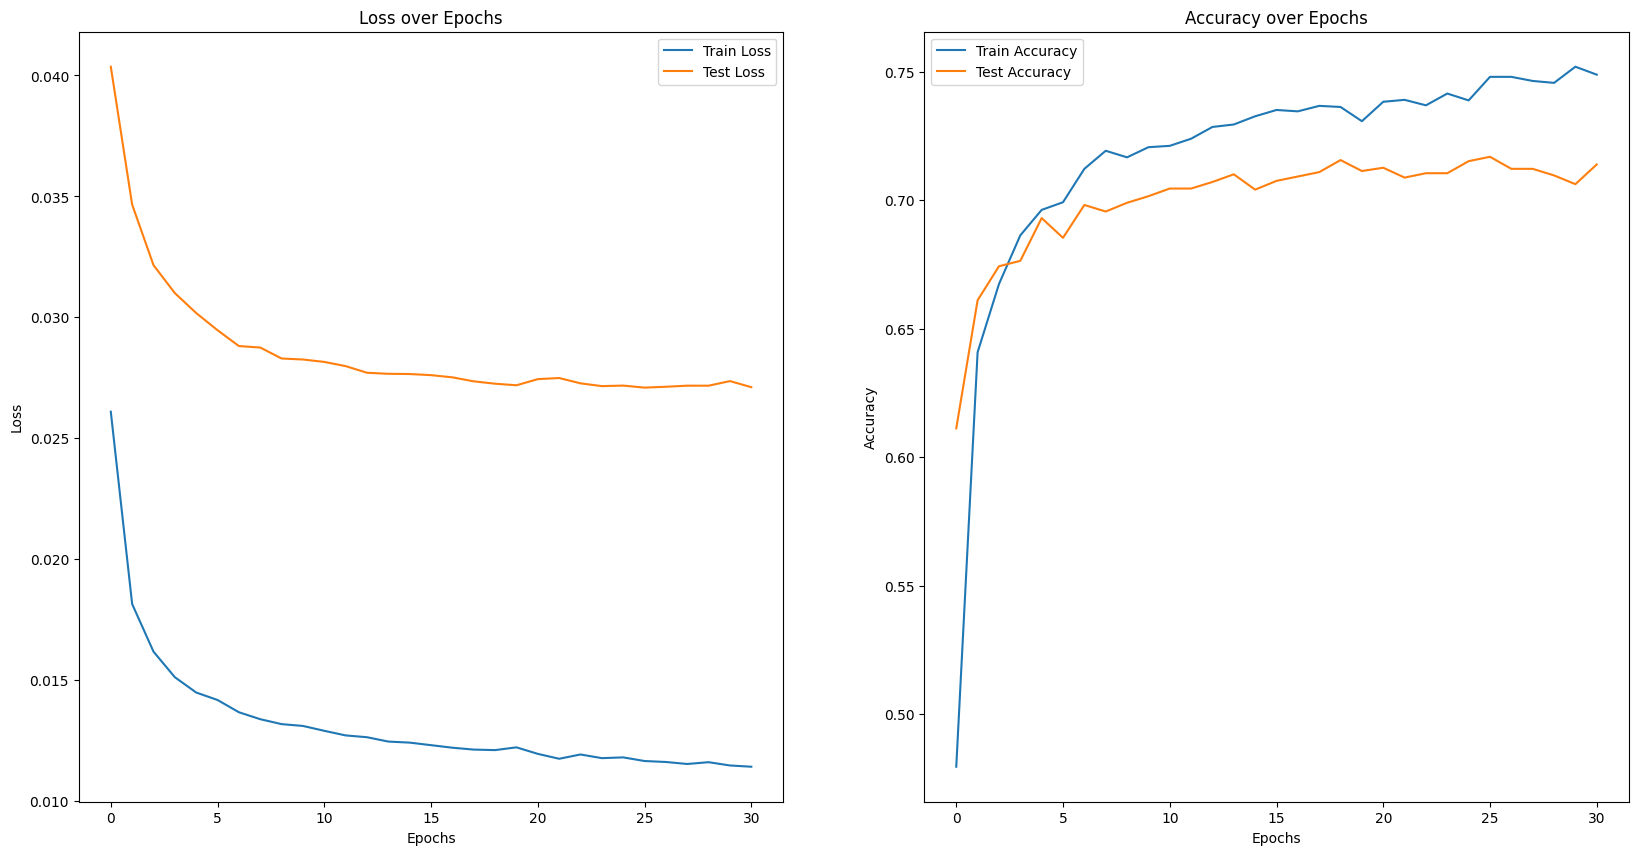

In [57]:
import matplotlib.pyplot as plt

# Make sure to include this line if you're using a Jupyter notebook
# %matplotlib inline

# Plotting the results
plt.figure(figsize=(20, 10))

# Plot for training and validation loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot for training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Show the plots
plt.show()


C:\Users\Manas\AppData\Local\Temp\ipykernel_23564\1602652278.py:41: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(pad=0)  # Ensures everything fits without padding


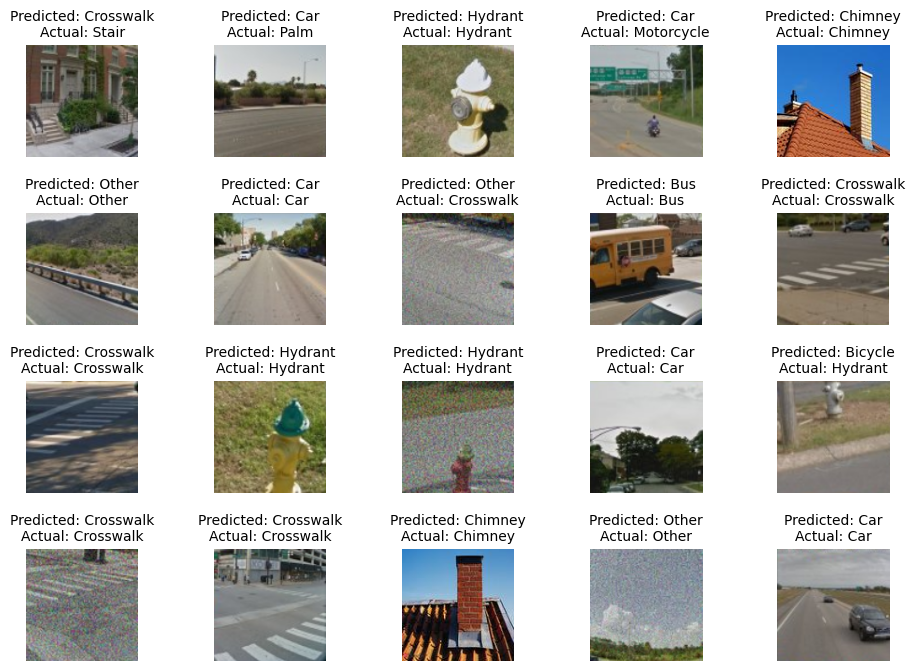

In [78]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import torchvision
import torch

# Load the best model
model.load_state_dict(torch.load('best_model.pth'))
model = model.to(device)
model.eval()

num_images = 20
fig = plt.figure(figsize=(12, 8))  # Adjust overall size to fit your needs
gs = gridspec.GridSpec(4, 5, wspace=0.05, hspace=0.5)  # Adjust spacing directly

class_images = []
while len(class_images) < num_images:
    inputs, labels = next(iter(test_loader))
    inputs, labels = inputs.to(device), labels.to(device)
    
    # Get predictions
    with torch.no_grad():
        outputs = model(inputs)
    _, preds = torch.max(outputs, 1)

    for img, pred, actual in zip(inputs, preds, labels):
        if len(class_images) < num_images:
            class_images.append((img, actual, pred))
        else:
            break

for idx, (image, actual, pred) in enumerate(class_images):
    ax = fig.add_subplot(gs[idx])
    image = image.cpu().numpy().transpose((1, 2, 0))
    image = std * image + mean  # Unnormalize
    image = np.clip(image, 0, 1)
    ax.imshow(image)
    ax.set_title(f'Predicted: {categories[pred]}\nActual: {categories[actual]}', fontsize=10)
    ax.axis('off')  # Hides the axis

plt.tight_layout(pad=0)  # Ensures everything fits without padding
plt.show()

